In [15]:
import json
from pathlib import Path
import base64
from getpass import getpass

from IPython.display import Image
import instructor
from openai import OpenAI
import pandas as pd
from pydantic import BaseModel
from datetime import date
import os
from dotenv import load_dotenv

load_dotenv()
openai_key = os.getenv("OPENAI_API_KEY")
openai_client = OpenAI(api_key=openai_key)


In [16]:
RAW_DATA_PATH = Path("dane_gaz") / "raw"

PROCESSED_DATA_PATH = Path("dane_gaz") / "processed"

In [ ]:
for image_path in RAW_DATA_PATH.glob("*.png"):
    print(image_path)

In [ ]:
Image(RAW_DATA_PATH / "gaz_2023_12.png")

In [14]:
def prepare_image_for_open_ai(image_path: Path) -> bytes:
    with open(image_path, 'rb') as f:
        image_data = base64.b64encode(f.read()).decode('utf-8')

    return f"data:image/png;base64,{image_data}"


In [ ]:
for image_path in RAW_DATA_PATH.glob('*.png'):
    print(f"Precessing {image_path}")

    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": """
wyciągnij wszystkie informacje zawarte na fakturze.
Dane przedstaw w formacie JSON.
Oczekuję następujących informacji:
{
    "razem_sprzedaż_okres_rozliczeniowy_data_od": ...,
    "razem_sprzedaż_okres_rozliczeniowy_data_do": ...,
    "zużycie_m3": ...,
    "zużycie_kWh": ...,
    "do_zapłaty": ...,
    "termin_płatności": ...,
}
tylko dane jako JSON, bez żadnych komentarzy.
"""
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": prepare_image_for_open_ai(image_path),
                            "detail": "high"
                        },
                    },
                ],
            }
        ],
    )

    result = response.choices[0].message.content.replace("```json", "").replace("```","").strip()
    with open(PROCESSED_DATA_PATH / f"{image_path.stem}__simple.json", "w") as f:
        f.write(result)


In [26]:
class GasBillInfo(BaseModel):
    okres_rozliczeniowy_od: date
    okres_rozliczeniowy_do: date
    zuzycie_m3: float
    zuzycie_kWh: float
    do_zaplaty: float
    termin_platnosci: date


instructor_openai_client = instructor.from_openai(OpenAI(api_key=api_key))

In [29]:
for image_path in sorted(RAW_DATA_PATH.glob('*.png')):
    print(f"Precessing {image_path}")

    gas_bill = instructor_openai_client.chat.completions.create(
        model ="gpt-4o-mini",
        response_model=GasBillInfo,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Pobierz szczegóły rachunku za gaz",
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": prepare_image_for_open_ai(image_path),
                            "detail": "high",
                        },
                    },
                    
                ],
            },
        ],
    )
    with open(PROCESSED_DATA_PATH / f"{image_path.stem}.json", "w") as f:
        f.write(gas_bill.model_dump_json())

Precessing dane_gaz\raw\gaz_2023_12.png
Precessing dane_gaz\raw\gaz_2024_01.png
Precessing dane_gaz\raw\gaz_2024_02.png
Precessing dane_gaz\raw\gaz_2024_03.png
Precessing dane_gaz\raw\gaz_2024_04.png
Precessing dane_gaz\raw\gaz_2024_05.png
Precessing dane_gaz\raw\gaz_2024_06.png
Precessing dane_gaz\raw\gaz_2024_07.png


In [30]:
data = []
for json_path in PROCESSED_DATA_PATH.glob('*.json'):
    if "simple" in json_path.name:
        continue

    with open(json_path) as f:
        data.append(json.loads(f.read()))
        
df = pd.DataFrame(data)
df

,okres_rozliczeniowy_od,okres_rozliczeniowy_do,zuzycie_m3,zuzycie_kWh,do_zaplaty,termin_platnosci
0,2023-03-01,2024-02-29,130.0,1505.0,463.55,2023-12-18
1,2023-03-01,2024-02-29,184.0,2124.0,644.73,2024-01-16
2,2023-03-01,2024-02-29,191.0,2204.0,668.14,2024-02-19
3,2024-03-01,2024-03-02,98.0,1128.0,353.21,2024-03-18
4,2024-03-01,2024-02-28,84.0,960.0,304.03,2024-04-16
5,2024-03-03,2024-04-01,35.0,394.0,138.38,2024-05-16
6,2024-03-01,2024-02-28,3.0,34.0,33.00,2024-06-17
7,2023-03-01,2024-02-28,6.0,69.0,46.90,2024-07-15


<Axes: xlabel='termin_platnosci'>

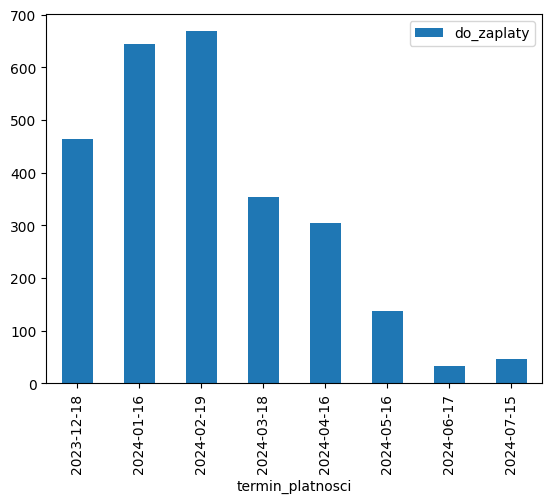

In [32]:
df.sort_values("termin_platnosci").plot(x="termin_platnosci", y="do_zaplaty", kind="bar")